## Motion correction with 2-photon imaging data using ANTs

We noticed in preliminary analyses that ants.motion_correction() sometimes failed badly on 2-photon imaging data, whereas ants.registration() had worked in previous analyses.  This notebook applies both workflows (with both SyN and Rigid transforms) to a small test dataset.

Summary:
- 

In [1]:
import ants
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('../scripts')
sys.path.append('../brainsss')
from timeit import default_timer as timer
from ants_utils import get_motion_parameters_from_transforms

basedir = '/data/brainsss/processed/fly_003/func_0'
basedir = '/Users/poldrack/data_unsynced/brainsss/flydata/processed/fly_003/func_0'

In [2]:
ants.__version__

'0.3.2'

In [3]:
# setup utility functions

def plot_image_means(antsimg, slice_to_show=20):
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    imgmeans = antsimg.mean(axis=(0,1,2))
    plt.plot(imgmeans)
    plt.ylabel('total image mean')
    plt.subplot(1,3,2)
    plt.imshow(
        antsimg[:,:,slice_to_show, np.argmin(imgmeans)],
        cmap='gray')
    plt.title('signal from lowest mean timepoint')
    plt.subplot(1,3,3)
    plt.imshow(
        antsimg[:,:,slice_to_show, np.argmax(imgmeans)],
        cmap='gray')
    plt.title('signal from highest mean timepoint')

def compute_similarity_to_mean(img, meanimg, metric_type='Correlation'):
    simvals = np.zeros(img.shape[3])
    for idx in range(img.shape[3]):
        simvals[idx] = ants.image_similarity(
            ants.utils.slice_image(img, axis=3, idx=idx),
            meanimg, metric_type=metric_type)
        if 'Correlation' in metric_type:
            simvals[idx] *= -1
    return(simvals)

def compute_timeseries_similarity(img1, img2, metric_type='Correlation'):
    assert img1.shape == img2.shape, 'images must have identical shape'
    return np.corrcoef(img1[:,:,:,:].flatten(),img2[:,:,:,:].flatten())

### Data setup

We will use a small test dataset here to reduce processing times

In [4]:
origfile = os.path.join(basedir, 'imaging/functional_channel_1.nii')
meanfile = os.path.join(basedir, 'imaging/functional_channel_1_mean.nii')


In [5]:
origimg = nib.load(origfile)
meanimg = nib.load(meanfile)

orig_ants = ants.image_read(origfile)
mean_ants = ants.image_read(meanfile)

# setup dicts to hold results
elapsed_time = {}
mean_similarity = {}
motpar = {}


In [6]:
use_mm_spacing = True
if use_mm_spacing:
    orig_ants.set_spacing([i * 1000 for i in orig_ants.spacing])
    mean_ants.set_spacing([i * 1000 for i in mean_ants.spacing])


### Rigid alignment using ants.motion_correction

In [33]:
total_sigma = 0
flow_sigma = 3

start = timer()
mytx = ants.motion_correction(
    image=orig_ants,
    fixed=mean_ants,
    verbose=True,
    type_of_transform='Rigid',
    total_sigma=total_sigma,
    flow_sigma=flow_sigma)
elapsed_time['rigid_moco'] = timer() - start
print(f'completed in {elapsed_time["rigid_moco"]:.2f} seconds')

Progress:
0%.Done
completed in 53.97 seconds


Here we plot the mean image intensity over time, which shows that there are a number of timepoints with highly divergent signal.  An image of one of those timepoints shows that the registration failed catastrophically.  Not shown here, but rerunning several times results in failure at different time points.

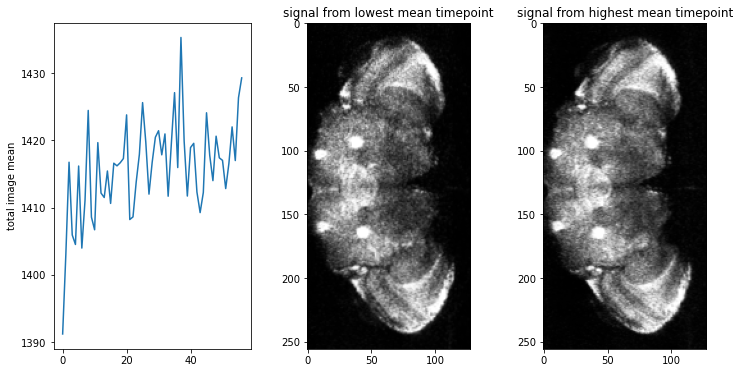

In [46]:
plot_image_means(mytx['motion_corrected'])

In [35]:
motpar['rigid_moco'] = get_motion_parameters_from_transforms(mytx['motion_parameters'])[1]

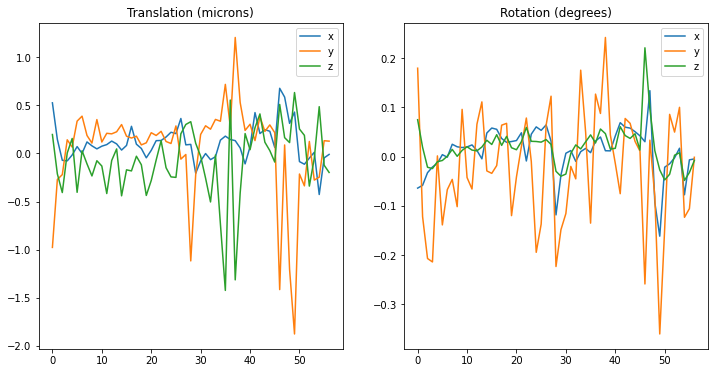

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(motpar['rigid_moco'][:,:3])
plt.title('Translation (microns)')
plt.legend(['x','y','z'])
plt.subplot(1,2,2)
plt.plot(motpar['rigid_moco'][:,3:])
plt.title('Rotation (degrees)')
plt.legend(['x','y','z'])

We can also compute the image similarity between each frame of the motion corrected image and the target (mean image), to see how well the image registration worked.

In [76]:
imgsim_rigid_moco = compute_similarity_to_mean(mytx['motion_corrected'], mean_ants)

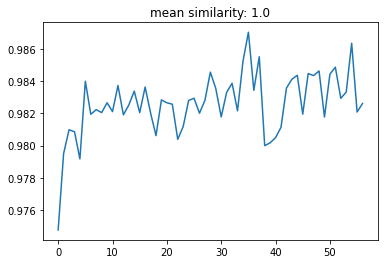

In [78]:
plt.plot(imgsim_rigid_moco)
plt.title(f'mean similarity: {np.mean(imgsim_rigid_moco):.1f}')
mean_similarity['rigid_moco'] = np.mean(imgsim_rigid_moco)

### SyN correction using ants.motion_correction

In [39]:
start = timer()
mytx_syn = ants.motion_correction(image=orig_ants, fixed=mean_ants,
    verbose=True, type_of_transform='SyN',
    total_sigma=total_sigma, flow_sigma=flow_sigma)
elapsed_time['syn_moco'] = timer() - start
print(f'completed in {elapsed_time["syn_moco"]:.2f} seconds')

Progress:
0%.Done
completed in 414.84 seconds


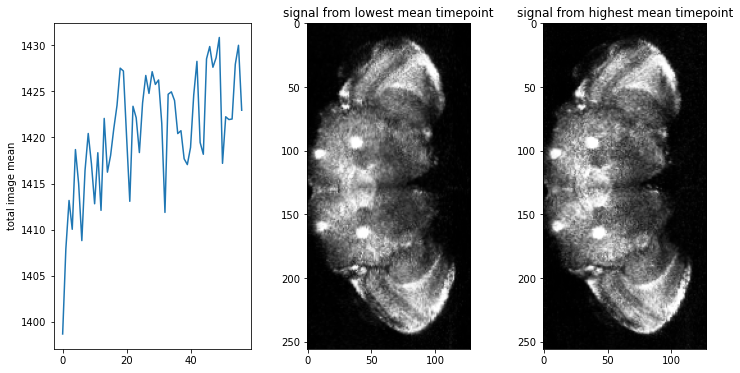

In [47]:
plot_image_means(mytx_syn['motion_corrected'])

In [79]:
imgsim_syn_moco = compute_similarity_to_mean(mytx_syn['motion_corrected'], mean_ants)

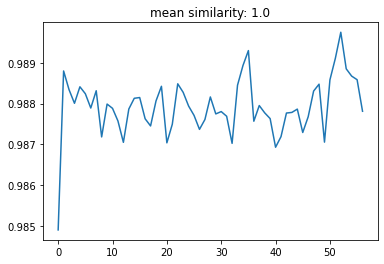

In [80]:
plt.plot(imgsim_syn_moco)
plt.title(f'mean similarity: {np.mean(imgsim_syn_moco):.1f}')
mean_similarity['syn_moco'] = np.mean(imgsim_syn_moco)

In [43]:
motpar['syn_moco'] = get_motion_parameters_from_transforms(mytx['motion_parameters'])[1]

### motion correction using frame-by-frame registration with ants.registration

In [48]:
## single shot ants registration

antsreg = {}
for idx in range(orig_ants.shape[-1]):
    antsreg[idx] = ants.registration(fixed=mean_ants,
                            moving=ants.utils.slice_image(orig_ants, axis=3, idx=idx),
                            type_of_transform='Rigid',
                            flow_sigma=flow_sigma,
                            total_sigma=total_sigma)
    

In [57]:
# put images back together

combined_data = nib.Nifti1Image(np.zeros(origimg.shape), affine=origimg.affine)

for idx in range(orig_ants.shape[-1]):
        combined_data.dataobj[:, :, :, idx] = antsreg[idx]['warpedmovout'][:, :, :]

In [58]:
combined_ants = ants.from_nibabel(combined_data)

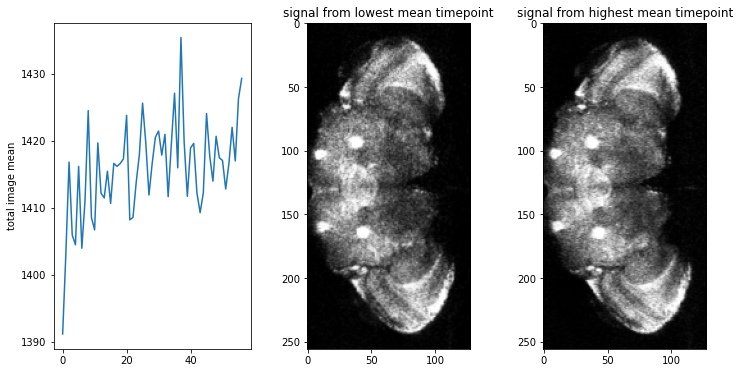

In [59]:
plot_image_means(combined_ants)

In [81]:
imgsim_syn_iter = compute_similarity_to_mean(combined_ants, mean_ants)

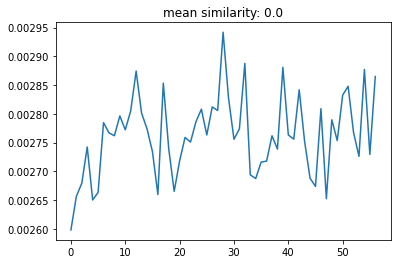

In [82]:
plt.plot(imgsim_syn_iter)
plt.title(f'mean similarity: {np.mean(imgsim_syn_iter):.1f}')
mean_similarity['syn_iter'] = np.mean(imgsim_syn_iter)

In [62]:
#motpar['syn_iter'] = get_motion_parameters_from_transforms(mytx['motion_parameters'])[1]

In [83]:
mean_similarity

{'rigid_moco': 0.9826105142894545,
 'syn_moco': 0.9879298597051386,
 'syn_iter': 0.0027630800266929888}

In [96]:
compute_timeseries_similarity(mytx['motion_corrected'], combined_ants)

array([[1.        , 0.99992575],
       [0.99992575, 1.        ]])

In [94]:
np.corrcoef(combined_ants[:,:,:,:].flatten(),mytx['motion_corrected'][:,:,:,:].flatten())

array([[1.        , 0.99992575],
       [0.99992575, 1.        ]])